## Modul

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn import metrics

## Preprocessing

In [ ]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0')
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    
    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

## Encoding

In [49]:
categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
# -> One Hot Encoding
def ohe_feature_names(feature, category):
    return str(feature) + "_" +str(category[:8])
encoder_ohe = OneHotEncoder(sparse_output= False, drop='if_binary', min_frequency= 5, feature_name_combiner= ohe_feature_names)
features_ohe = encoder_ohe.fit_transform(Data[categorical_features]) 

# making Dataframe
Raw_Data_wo_categories = Data.drop(columns=categorical_features, inplace= False)
Data_ohe = pd.concat ([Raw_Data_wo_categories.reset_index(drop=True), pd.DataFrame(features_ohe, columns= encoder_ohe.get_feature_names_out()).reset_index(drop= True)], axis=1) #One Hot Encoded Data

## Splitting

In [51]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(Data_ohe, Attack_label, train_size=10000, test_size=30000, random_state=22)
_, _, Y_ref, _ = train_test_split(Data, Attack_type, train_size=10000 ,test_size=30000, random_state=22)

## Training and Testing Dataset for PCA
pca = PCA(n_components=15).fit(X_train)
#X_train_PCA = pca.transform(X_train)
#X_test_PCA = pca.transform(X_test)

In [52]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=Data_ohe.columns)

X_test = scaler.fit_transform(X_test)
X_test_PCA = pca.transform(X_test)


X_train, Y_train = SMOTEENN(random_state= 22).fit_resample(X_train_scaled, Y_train)
X_train_PCA = pca.transform(X_train)

## Scaling the Dataset

In [5]:
# Robust-Scaling the Dataset
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
Data_ohe_scaled = scaler.fit_transform(Data_ohe)
Data_ohe_scaled = pd.DataFrame(Data_ohe_scaled, columns=Data_ohe.columns)

In [6]:
# Dropping Duplicates
Data_ohe_scaled = Data_ohe_scaled.drop_duplicates(keep='first')
Attack_type = Attack_type[Data_ohe_scaled.index]
attack_label = attack_label[Data_ohe_scaled.index]

In [7]:
#SMOTEENN
Data_ohe_scaled['Attack_type'] = Attack_type
Dataset, Target_label = SMOTEENN(random_state= 22).fit_resample(Data_ohe_scaled, attack_label)
Target_type = Dataset.pop('Attack_type')

## Train split

In [8]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_label, train_size=2000, test_size=30000, random_state=22)
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=10000 ,test_size=30000, random_state=22)

## Training and Testing Dataset for PCA
pca = PCA(n_components=15).fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)


## Functions

In [35]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  

#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Function for Evaluation
def evaluate_bin(test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    tn, fp, fn, tp = metrics.confusion_matrix(test, pred, labels=[0,1]).ravel()
    df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                              'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100}, 
                              index= ['Anomaly'])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Anomaly']) #normalize= 'true'
    return df_metric

#Function for looping training and testing
def train_and_eval(model, x, y, pca:bool = False) -> pd.DataFrame:
    if pca:
        y_pred= model.fit(X_train_PCA, y).predict(X_test_PCA)
        return evaluate_bin(Y_test, y_pred, display=False)
    else:
        y_pred = model.fit(x, y).predict(X_test)
        return evaluate_bin(Y_test, y_pred, display=False)

#Classes for pipeline
class SampleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.is_fitting = False
    
    def fit(self, X, y=None):
        self.is_fitting = True
        return self
    
    def transform(self, X, y=None):
        if self.is_fitting:
            X_sampled = X[:self.num_samples]
            if y is not None:
                y_sampled = y[:self.num_samples]
                return X_sampled , y_sampled
            else:
                return X_sampled
        else:
            return X
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
# Custom pipeline to handle different behavior during fit and predict
class CustomPipeline(Pipeline):
    def fit(self, X, y=None, **fit_params):
        Xt, yt = self._fit_transform(X, y, **fit_params)
        self.steps[-1][-1].fit(Xt, yt, **fit_params)
        return self

    def _fit_transform(self, X, y=None, **fit_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                X, y = transform.fit_transform(X, y)
        return X, y

    def predict(self, X, **predict_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                transform.is_fitting = False  
                X = transform.transform(X)
        return self.steps[-1][-1].predict(X, **predict_params)

## Models

### LOF

,Average Accuracy Score,Precision,Recall,F1-Score,FPR
Anomaly,83.656667,91.658876,88.775591,90.194196,11.224409


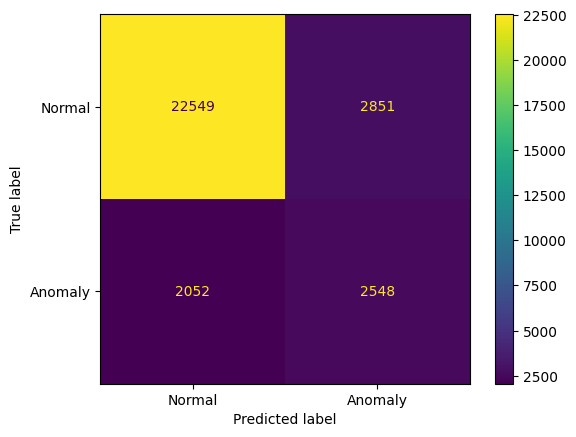

In [53]:
lof = LocalOutlierFactor(novelty=True, n_neighbors=20, metric='manhattan', leaf_size=6)
index_0 = np.where(Y_train == 0)
X_novelty = X_train.iloc[index_0]
Y_novelty = Y_train.iloc[index_0]
Y_novelty = np.ones(Y_novelty.shape)
lof = lof.fit(X_novelty)
y_pred = lof.predict(X_test)
Y_novelty_test = Y_test.replace({0:1, 1:-1})

tn, fp, fn, tp = metrics.confusion_matrix(Y_novelty_test, y_pred, labels=[-1,1]).ravel()
df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(Y_novelty_test, y_pred)*100,                              
                              'Precision':metrics.precision_score(Y_novelty_test, y_pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(Y_novelty_test, y_pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(Y_novelty_test, y_pred, pos_label= -1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100}, 
                              index= ['Anomaly'])
metrics.ConfusionMatrixDisplay.from_predictions(Y_novelty_test, y_pred, display_labels=['Normal', 'Anomaly']) #normalize= 'true'
df_metric

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

svc = SVC() 
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[150, 200, 500],}

X_std = StandardScaler().fit_transform(X_train)


# Set up the GridSearchCV
grid_search = GridSearchCV(svc, parameters, cv=5)

# fitting grid search
grid_search.fit(X_std, Y_train)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


In [54]:
rf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.5, max_samples= 0.5, n_estimators= 60, random_state=22)
knn = KNeighborsClassifier(leaf_size= 2, n_neighbors= 3, p= 1, weights= 'distance')
vote_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf)], voting='soft')
svc = SVC(C= 200, kernel= 'poly', probability= True)

models = {'KNN':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('knn', knn)]),
          'Random Forest':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=10000)), ('rf', rf)]),
          #'SVC':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=1000)), ('std', StandardScaler()), ('svc', svc)]),
          'Voting Ensemble':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('vote_clf', vote_clf)])
          }

In [55]:
# Binary Classifiers
clf_results = pd.DataFrame()
clf_results_pca = pd.DataFrame()

for model_name, model in models.items(): 
    clf_results = pd.concat([clf_results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)
    clf_results_pca = pd.concat([clf_results_pca, train_and_eval(model, X_train_PCA, Y_train, True)], axis=0, ignore_index=True)

clf_results.index = pd.MultiIndex.from_product([['KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model'])
clf_results_pca.index = pd.MultiIndex.from_product([['KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model after PCA'])
print(clf_results)
print(clf_results_pca)

                 Average Accuracy Score  Precision     Recall   F1-Score  \
Model                                                                      
KNN                           15.333333   0.000000   0.000000   0.000000   
Random Forest                 91.500000  99.330743  90.570866  94.748764   
Voting Ensemble               15.333333   0.000000   0.000000   0.000000   

                      FPR  
Model                      
KNN              0.000000  
Random Forest    3.369565  
Voting Ensemble  0.000000  
                 Average Accuracy Score  Precision     Recall  F1-Score  \
Model after PCA                                                           
KNN                           15.333333   0.000000   0.000000   0.00000   
Random Forest                 86.646667  99.417906  84.724409  91.48493   
Voting Ensemble               15.333333   0.000000   0.000000   0.00000   

                     FPR  
Model after PCA           
KNN              0.00000  
Random Forest    2.739

## Cross validation

In [46]:
from sklearn.model_selection import cross_val_score

for model_name, model in models.items():
     cv_scores = cross_val_score(model, X_train, Y_train, cv=4)
     print(f"{model_name} CV Scores: {cv_scores}")
     

KNN CV Scores: [0.50419948 0.50419948 0.50433185 0.50406931]
Random Forest CV Scores: [0.99317585 0.99265092 0.99081124 0.9905487 ]
Voting Ensemble CV Scores: [0.50419948 0.50419948 0.50433185 0.50406931]


## Novel attack evaluation

In [90]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]

model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results

Average Accuracy Score  Precision     Recall  \
Model           Novel Type                                                   
KNN             novel type 1               92.563333  94.896532  90.043118   
                novel type 2               92.946667  94.825320  90.925373   
                novel type 3               92.723333  94.241592  91.084577   
                novel type 4               90.983333  96.496767  85.147595   
                novel type 5               90.216667  95.244484  84.762852   
Random Forest   novel type 1               88.766667  98.620919  78.746269   
                novel type 2               92.540000  95.518048  89.346600   
                novel type 3               95.050000  95.782240  94.301824   
                novel type 4               94.226667  99.312588  89.127695   
                novel type 5               94.373333  97.515440  91.124378   
Voting Ensemble novel type 1               93.450000  96.000000  90.746269   
                novel type 2               93.786667  95.836514  91.615257   
                novel type 3               93.713333  95.282565  92.046434   
                novel type 4               91.923333  97.664256  85.983416   
                novel type 5               91.683333  96.489283  86.600332   

                               F1-Score       FPR  
Model           Novel Type                         
KNN             novel type 1  92.406140  4.891122  
                novel type 2  92.834406  5.011725  
                novel type 3  92.636195  5.621441  
                novel type 4  90.467632  3.122278  
                novel type 5  89.698501  4.274707  
Random Forest   novel type 1  87.570080  1.112228  
                novel type 2  92.329312  4.234506  
                novel type 3  95.036267  4.194305  
                novel type 4  93.944903  0.623116  
                novel type 5  94.211645  2.345059  
Voting Ensemble novel type 1  93.299233  3.819095  
                novel type 2  93.678356  4.020101  
                novel type 3  93.636548  4.603015  
                novel type 4  91.452358  2.077052  
                novel type 5  91.277749  3.182580